In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from src.configspace import (
    COX_PH_CONFIGSPACE,
    GB_COX_CONFIGSPACE,
    GPR_CONFIGSPACE,
    POLY_RIDGE_CONFIGSPACE,
    RANDOM_FOREST_CONFIGSPACE,
    RANDOM_SURVIVAL_FOREST_CONFIGSPACE,
    RIDGE_CONFIGSPACE,
    SCHMEE_HAHN_QRF_CONFIGSPACE,
    SVR_CONFIGSPACE,
    XGB_AFT_CONFIGSPACE,
    XGB_CONFIGSPACE,
)
from src.constant import (
    HO,
    PROCESSED_DATA_DIR,
    RANDOM_STATE_LIST,
    RESULTS_PERMUTATION_DIR,
    SOLVER_NUMBER_LIST,
)
from src.evaluation import evaluate_model_with_cross_validation
from src.hyperparameter_optimization import optimize_hyperparameters
from src.model import (
    SVR,
    CoxPHSurvivalAnalysis,
    GPRWithRBF,
    GradientBoostingSurvivalAnalysis,
    PolynomialRidge,
    RandomForestRegressor,
    RandomSurvivalForest,
    Ridge,
    SchmeeHahnQRF,
    TobitModel,
    XGBRegressor,
    XGBRegressorAFT,
)
from src.results import plot_line, plot_scatter
from src.split import get_n_splits
from src.wrapper import (
    ScikitLearnWrapper,
    SkipCutOffScikitLearnWrapper,
    StandardScaledLogTransformedWrapper,
    SurvivalFunctionWrapper,
    XGBwrapper,
)

In [2]:
evaluations_df = pd.read_parquet(PROCESSED_DATA_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DATA_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DATA_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,generator,cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,EXTRA_CANDIDATE_SET_TYPE,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,4.74,0.95,1.0,0.0,0.0,0.2,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,0.02,0.15,0.0,1.0,1.0,0.4,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,3.72,0.20,0.0,1.0,2.0,0.9,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,1.52,0.60,1.0,1.0,2.0,0.7,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,84.44,0.90,1.0,1.0,3.0,0.3,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1286196444435323941,TSP/TRAIN/grid/019.tsp,grid,208.32,0.45,0.0,0.0,0.0,0.2,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99996,1435531534300921454,TSP/TRAIN/grid/019.tsp,grid,300.00,0.20,1.0,0.0,3.0,0.6,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99997,27607668447685341,TSP/TRAIN/grid/019.tsp,grid,3.21,0.95,1.0,1.0,3.0,0.9,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99998,2245205590089179674,TSP/TRAIN/grid/019.tsp,grid,17.23,0.65,0.0,0.0,1.0,0.5,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201


In [3]:
PERMUATION_LOGNORMAL_MEAN_SIGMA = (0, 1)

In [4]:
SPLITS = get_n_splits(
    df=df,
    n=HO.N,
    instance_number=HO.INSTANCE_NUMBER,
    solver_number=HO.SOLVER_NUMBER,
    random_state=HO.RANDOM_STATE,
)

### Ridge

In [5]:
ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=Ridge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RIDGE_CONFIGSPACE,
    splits=SPLITS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_PERMUTATION_DIR / "HO" / "ridge_incumbent.pkl",
)

ridge_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=Ridge,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=RIDGE_CONFIGSPACE,
    splits=SPLITS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_PERMUTATION_DIR / "HO" / "ridge_incumbent_skip_cutoff.pkl",
)

### PolynomialRidge

In [6]:
poly_ridge_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=PolynomialRidge,
    wrapper_cls=ScikitLearnWrapper,
    configspace=POLY_RIDGE_CONFIGSPACE,
    splits=SPLITS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_PERMUTATION_DIR / "HO" / "poly_ridge_incumbent.pkl",
)

poly_ridge_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=PolynomialRidge,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=POLY_RIDGE_CONFIGSPACE,
    splits=SPLITS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_PERMUTATION_DIR / "HO" / "poly_ridge_incumbent_skip_cutoff.pkl",
)

### RandomForestRegressor

In [7]:
rf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=RandomForestRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=RANDOM_FOREST_CONFIGSPACE,
    splits=SPLITS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_PERMUTATION_DIR / "HO" / "rf_incumbent.pkl",
)

rf_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=RandomForestRegressor,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=RANDOM_FOREST_CONFIGSPACE,
    splits=SPLITS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_PERMUTATION_DIR / "HO" / "rf_incumbent_skip_cutoff.pkl",
)

### XGBRegressor

In [8]:
xgb_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressor,
    wrapper_cls=ScikitLearnWrapper,
    configspace=XGB_CONFIGSPACE,
    splits=SPLITS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_PERMUTATION_DIR / "HO" / "xgb_incumbent.pkl",
)

xgb_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressor,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=XGB_CONFIGSPACE,
    splits=SPLITS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_PERMUTATION_DIR / "HO" / "xgb_incumbent_skip_cutoff.pkl",
)

### SVR

In [9]:
svr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=SVR,
    wrapper_cls=ScikitLearnWrapper,
    configspace=SVR_CONFIGSPACE,
    splits=SPLITS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_PERMUTATION_DIR / "HO" / "svr_incumbent.pkl",
)

svr_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=SVR,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=SVR_CONFIGSPACE,
    splits=SPLITS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_PERMUTATION_DIR / "HO" / "svr_incumbent_skip_cutoff.pkl",
)

### GPRWithRBF

In [10]:
gpr_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=GPRWithRBF,
    wrapper_cls=ScikitLearnWrapper,
    configspace=GPR_CONFIGSPACE,
    splits=SPLITS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_PERMUTATION_DIR / "HO" / "gpr_incumbent.pkl",
)

gpr_incumbent_skip_cutoff = optimize_hyperparameters(
    df=df,
    model_cls=GPRWithRBF,
    wrapper_cls=SkipCutOffScikitLearnWrapper,
    configspace=GPR_CONFIGSPACE,
    splits=SPLITS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_PERMUTATION_DIR / "HO" / "gpr_incumbent_skip_cutoff.pkl",
)

### CoxPHSurvivalAnalysis

In [11]:
coxph_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=CoxPHSurvivalAnalysis,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=COX_PH_CONFIGSPACE,
    splits=SPLITS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_PERMUTATION_DIR / "HO" / "coxph_incumbent.pkl",
)
coxph_incumbent

{'alpha': 13.6880493422333,
 'risk_function': 'polynomial',
 'ties': 'breslow',
 'risk_alpha': 0.553369716052,
 'model_cls': sksurv.linear_model.coxph.CoxPHSurvivalAnalysis}

### RandomSurvivalForest

In [12]:
rsf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=RandomSurvivalForest,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=RANDOM_SURVIVAL_FOREST_CONFIGSPACE,
    splits=SPLITS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_PERMUTATION_DIR / "HO" / "rsf_incumbent.pkl",
)
rsf_incumbent

{'max_depth': 7,
 'max_features': 0.949975513741,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_jobs': -1,
 'random_state': 0,
 'risk_function': 'exponential',
 'risk_alpha': 1.718875737677,
 'risk_beta': 11.7850369367298,
 'model_cls': sksurv.ensemble.forest.RandomSurvivalForest}

### GradientBoostingSurvivalAnalysis

In [13]:
gb_cox_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=GradientBoostingSurvivalAnalysis,
    wrapper_cls=SurvivalFunctionWrapper,
    configspace=GB_COX_CONFIGSPACE,
    splits=SPLITS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_PERMUTATION_DIR / "HO" / "gb_cox_incumbent.pkl",
)
gb_cox_incumbent

{'ccp_alpha': 0.0023850197557,
 'learning_rate': 0.2319669631084,
 'loss': 'coxph',
 'max_depth': 5,
 'max_features': 0.7194957289126,
 'min_samples_leaf': 32,
 'min_samples_split': 5,
 'n_estimators': 472,
 'random_state': 0,
 'risk_function': 'polynomial',
 'subsample': 0.6286117496721,
 'risk_alpha': 0.8009472438586,
 'model_cls': sksurv.ensemble.boosting.GradientBoostingSurvivalAnalysis}

### XGBRegressorAFT

In [14]:
xgb_aft_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=XGBRegressorAFT,
    wrapper_cls=XGBwrapper,
    configspace=XGB_AFT_CONFIGSPACE,
    splits=SPLITS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_PERMUTATION_DIR / "HO" / "xgb_aft_incumbent.pkl",
)
xgb_aft_incumbent

{'aft_loss_distribution': 'logistic',
 'colsample_bytree': 0.6298013597726,
 'eval_metric': 'aft-nloglik',
 'gamma': 2.5000043394916,
 'learning_rate': 0.0732260708093,
 'max_depth': 3,
 'min_child_weight': 5,
 'num_boost_round': 627,
 'objective': 'survival:aft',
 'reg_alpha': 0.0059666994075,
 'reg_lambda': 0.0012793868001,
 'seed': 0,
 'subsample': 0.5567903424362,
 'aft_loss_distribution_scale': 0.7159987670782,
 'model_cls': src.model.XGBRegressorAFT}

### SchmeeHahnQRF

In [15]:
sh_qrf_incumbent = optimize_hyperparameters(
    df=df,
    model_cls=SchmeeHahnQRF,
    wrapper_cls=StandardScaledLogTransformedWrapper,
    configspace=SCHMEE_HAHN_QRF_CONFIGSPACE,
    splits=SPLITS,
    permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
    random_state=HO.RANDOM_STATE,
    n_trials=HO.N_TRIALS,
    filepath=RESULTS_PERMUTATION_DIR / "HO" / "sh_qrf_incumbent.pkl",
)
sh_qrf_incumbent

{'ccp_alpha': 0.0011004019939,
 'k': 20,
 'max_depth': 21,
 'max_features': 0.9038951337456,
 'min_samples_leaf': 14,
 'min_samples_split': 3,
 'n_jobs': -1,
 'random_state': 0,
 'model_cls': src.model.SchmeeHahnQRF}

### TobitModel

In [16]:
tobit_incumbent = {"model_cls": TobitModel}

tobit_incumbent

{'model_cls': src.model.TobitModel}

## Comparison

In [17]:
model_info_list = [
    # include cut-off
    {
        "wrapper": ScikitLearnWrapper(**ridge_incumbent),
        "name": "Ridge Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**poly_ridge_incumbent),
        "name": "Polynomial Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**svr_incumbent),
        "name": "Support Vector Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**gpr_incumbent),
        "name": "Gaussian Process Regression"
    },
    {
        "wrapper": ScikitLearnWrapper(**rf_incumbent),
        "name": "Random Forest"
    },
    {
        "wrapper": ScikitLearnWrapper(**xgb_incumbent),
        "name": "XGBoost"
    },
    # skip cut-off
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**ridge_incumbent_skip_cutoff),
        "name": "Ridge Regression (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**poly_ridge_incumbent_skip_cutoff),
        "name": "Polynomial Regression (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**svr_incumbent_skip_cutoff),
        "name": "Support Vector Regression (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**gpr_incumbent_skip_cutoff),
        "name": "Gaussian Process Regression (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**rf_incumbent_skip_cutoff),
        "name": "Random Forest (skip cut-off)"
    },
    {
        "wrapper": SkipCutOffScikitLearnWrapper(**xgb_incumbent_skip_cutoff),
        "name": "XGBoost (skip cut-off)"
    },
    # survival models
    {
        "wrapper": SurvivalFunctionWrapper(**coxph_incumbent),
        "name": "Cox PH"
    },
    {
        "wrapper": SurvivalFunctionWrapper(**rsf_incumbent),
        "name": "Random Survival Forest"
    },
    {
        "wrapper": SurvivalFunctionWrapper(**gb_cox_incumbent),
        "name": "Gradient Boosting Cox"
    },
    {
        "wrapper": XGBwrapper(**xgb_aft_incumbent),
        "name": "XGBoost AFT"
    },
    {
        "wrapper": StandardScaledLogTransformedWrapper(**sh_qrf_incumbent),
        "name": "S&H QRF"
    },
    {
        "wrapper": StandardScaledLogTransformedWrapper(**tobit_incumbent),
        "name": "NN Tobit"
    },
]
 
# total_iterations = len(RANDOM_STATE_LIST) * len(SOLVER_NUMBER_LIST) * len(model_info_list)
# pbar = tqdm(total=total_iterations, desc="Evaluating models")

# records = []

# for random_state in RANDOM_STATE_LIST:
#     for solver_number in SOLVER_NUMBER_LIST:
#         pbar.set_description(f"RS={random_state}, Solvers={solver_number}")
#         splits = get_n_splits(
#             df,
#             n=5,
#             instance_number=10,
#             solver_number=solver_number,
#             random_state=random_state,
#         )
#         for model_info in model_info_list:
#             pbar.set_postfix(model=model_info["name"])

#             result = evaluate_model_with_cross_validation(
#                 df,
#                 wrapper=model_info["wrapper"],
#                 splits=splits,
#                 random_state=random_state,
#                 permuation_lognormal_mean_sigma=PERMUATION_LOGNORMAL_MEAN_SIGMA,
#             )
#             result["random_state"] = random_state
#             result["solver_number"] = solver_number
#             result["name"] = model_info["name"]
#             records.append(result)
#             pbar.update(1)

# pbar.close()
# result_df = pd.DataFrame(records)
# result_df.to_pickle(RESULTS_PERMUTATION_DIR / "results.gzip", compression="gzip")

result_df = pd.read_pickle(RESULTS_PERMUTATION_DIR / "results.gzip", compression="gzip")

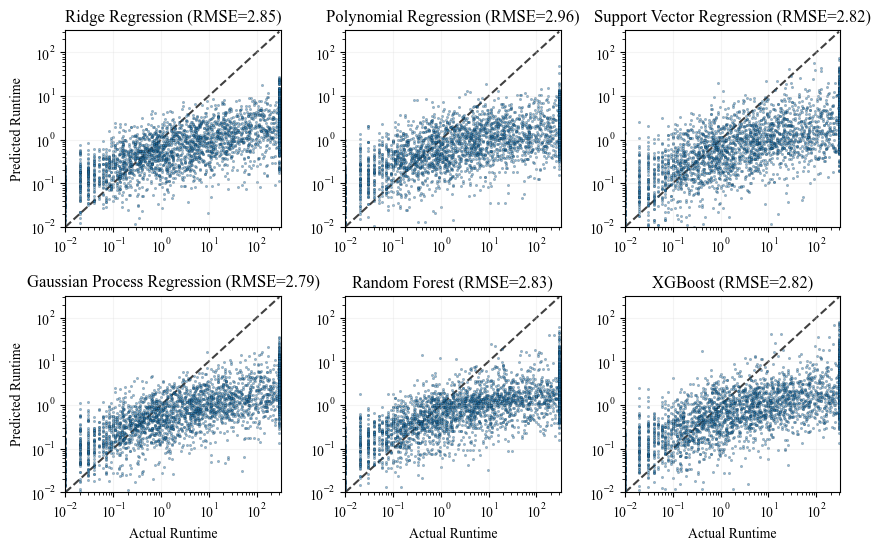

In [18]:
plot_df = result_df.loc[(result_df["random_state"] == 1) & (result_df["solver_number"] == 300)].iloc[:6].reset_index(drop=True)

fig, axs = plot_scatter(plot_df)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

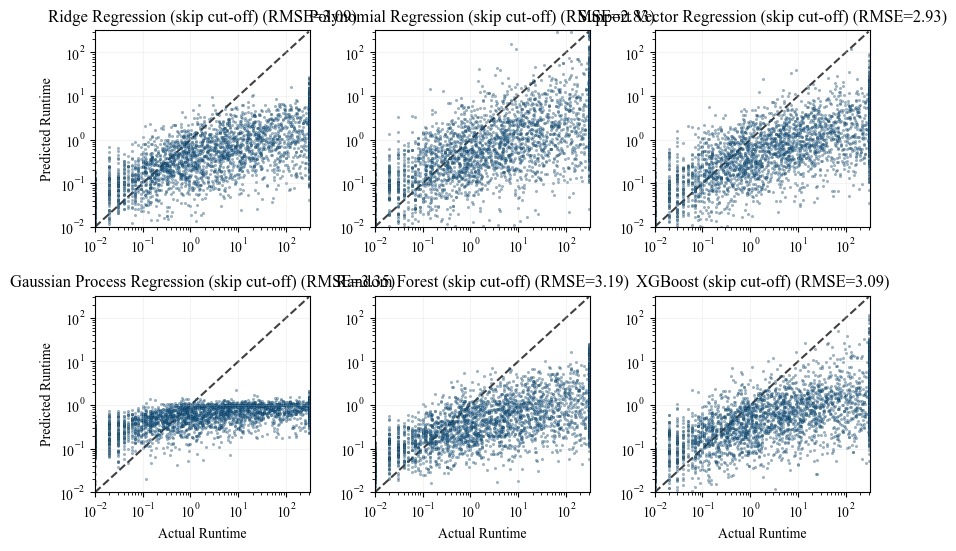

In [19]:
plot_df = result_df.loc[(result_df["random_state"] == 1) & (result_df["solver_number"] == 300)].iloc[6:12].reset_index(drop=True)

fig, axs = plot_scatter(plot_df)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

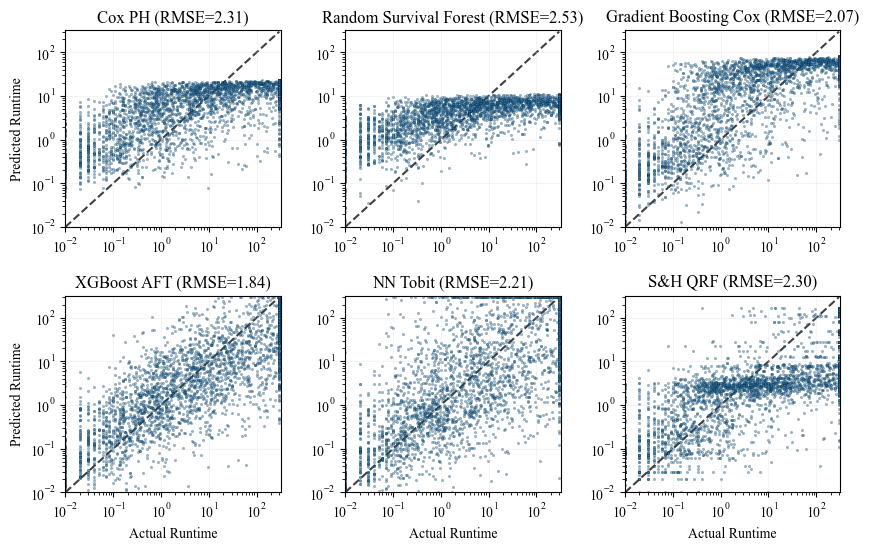

In [20]:
plot_df = result_df.loc[(result_df["random_state"] == 1) & (result_df["solver_number"] == 300)].iloc[12:].reset_index(drop=True)

fig, axs = plot_scatter(plot_df)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

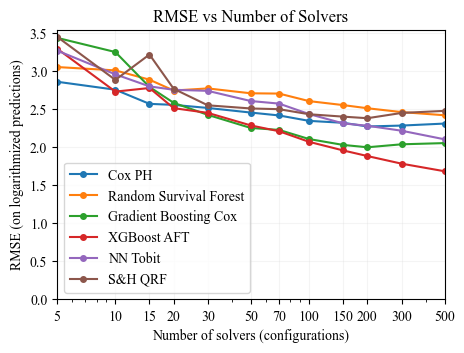

In [27]:
fig, ax = plot_line(
    result_df.loc[
        result_df["name"].isin(
            [
                "Cox PH",
                "Random Survival Forest",
                "Gradient Boosting Cox",
                "XGBoost AFT",
                "S&H QRF",
                "NN Tobit",
            ]
        )
    ]
)

plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

In [22]:
from scipy.stats import wilcoxon

result_agg = result_df.groupby(["solver_number", "name"], sort=False)["rmse"].mean().reset_index()

frames = []

for solver_number, group in result_agg.groupby("solver_number"):
    group = group.copy()
    best_rmse_i = group["rmse"].argmin()
    best_rsme_model = group.iloc[best_rmse_i]["name"]
    group["p"] = np.nan

    result_solver_number = result_df.loc[lambda x: x["solver_number"] == solver_number].pivot_table(index="random_state", columns="name", values="rmse")
    y = result_solver_number[best_rsme_model].to_numpy()

    for i, row in group.iterrows():
        if row["name"] == best_rsme_model:
            continue
        
        x = result_solver_number[row["name"]].to_numpy()

        stat, p = wilcoxon(x, y, zero_method='wilcox', alternative='greater', correction=True, method='auto')
        group.at[i, "p"] = p
    frames.append(group)

result_agg = pd.concat(frames)
p_values = result_agg.pivot_table(index="name", columns="solver_number", values="p")
result_agg = result_agg.pivot_table(index="name", columns="solver_number", values="rmse")

In [23]:
idx = [x["name"] for x in model_info_list]
p_values = p_values.loc[idx]
result_agg = result_agg.loc[idx]

In [25]:
mask = p_values.isna() | (p_values > 0.05 / (p_values.shape[0] - 1))

def highlight_mask(x):
    return ['font-weight: bold' if mask.loc[x.name, col] else '' for col in x.index]

styled_result = result_agg.style.apply(highlight_mask, axis=1).format(precision=3).highlight_min(axis=0)
styled_result.to_excel("tmp.xlsx")